In [3]:
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import catboost as cb
import missingno as msno

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

%matplotlib inline

In [4]:
import warnings
warnings.simplefilter("ignore")

In [10]:
DATA_PATH = './data'
TRAIN_PATH = os.path.join(DATA_PATH, 'train.csv')
TEST_PATH = os.path.join(DATA_PATH, 'test.csv')
CP_PATH = os.path.join(DATA_PATH, 'client_profile.csv')
BKI_PATH = os.path.join(DATA_PATH, 'bki.csv')
APP_HISTORY_PATH = os.path.join(DATA_PATH, 'applications_history.csv')
PAYMENTS_PATH = os.path.join(DATA_PATH, 'payments.csv')
TARGET_COLUMN = 'TARGET'

In [6]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 110093 rows, 3 cols
test.shape = 165141 rows, 2 cols


In [38]:
train_nunique_ids = train['APPLICATION_NUMBER'].nunique()
test_nunique_ids = test['APPLICATION_NUMBER'].nunique()

print(f'В тренировочной выборке {train_nunique_ids} уникальных клиентов')
print(f'В тестовой выборке {test_nunique_ids} уникальных клиентов')

В тренировочной выборке 110093 уникальных клиентов
В тестовой выборке 165141 уникальных клиентов


In [41]:
train_unique_ids = set(train['APPLICATION_NUMBER'].unique())
test_unique_ids = set(test['APPLICATION_NUMBER'].unique())

print(f'В тесте содержится {len(train_unique_ids.intersection(test_unique_ids))} клиентов из тренировочной выборки' )

В тесте содержится 0 клиентов из тренировочной выборки


In [48]:
print(f'Всего в тренировочном датасете пропущенных значений: {train.isna().values.sum()}')
print(f'Всего в тестовом датасете пропущенных значений: {test.isna().values.sum()}')

Всего в тренировочном датасете пропущенных значений: 0
Всего в тестовом датасете пропущенных значений: 0


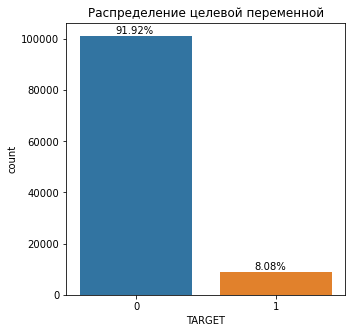

In [47]:
target = train[TARGET_COLUMN]
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x=TARGET_COLUMN, data=train, ax=ax)

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height() / train.shape[0] * 100), (p.get_x()+0.25, p.get_height()+1000))
    
plt.title('Распределение целевой переменной')
plt.show()

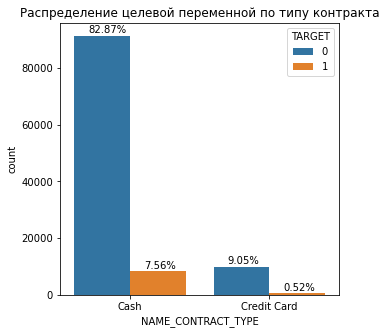

In [45]:
target = train[TARGET_COLUMN]
fig, ax = plt.subplots(figsize=(5, 5))
sns.countplot(x='NAME_CONTRACT_TYPE', data=train, ax=ax, hue=TARGET_COLUMN)

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height() / train.shape[0] * 100), (p.get_x()+0.1, p.get_height()+1000))
    
plt.title('Распределение целевой переменной по типу контракта')
plt.show()

**ВЫВОД**

* В тестовой выборке больше данных, чем в тренировочной
* Повторяющихся id в train и test нет
* Пропущенные значения отсутствуют
* Есть дисбаланс классов (92% - 8%)
* 90.5% всех контрактов типа Cash, только 9.5% типа Credit Card

### Client Profile

В таблице "профиль клиента" содержится основная, общая информация о клиентах. Id клинтов уникальны. При этом отсутствуют данные о 20554 клиентов из тренировочной выборки

In [11]:
cp_df = pd.read_csv(CP_PATH)

In [12]:
cp_df.head()

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387,...,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,123588799,M,0,112500.0,254700.0,17149.5,Secondary / secondary special,Married,0.019101,14273,...,2.0,NaN,0.308994,0.590233,0.0,0.0,0.0,0.0,0.0,3.0
4,123647485,M,0,130500.0,614574.0,19822.5,Lower secondary,Married,0.022625,22954,...,2.0,NaN,0.739408,0.156640,0.0,0.0,1.0,0.0,0.0,6.0


In [22]:
train_users = set(train['APPLICATION_NUMBER'].unique())
test_users = set(test['APPLICATION_NUMBER'].unique())
cp_users = set(cp_df['APPLICATION_NUMBER'].unique())

print(f'В таблице с профилем клиентов отсутствует информация для {len(train_users.difference(cp_users))} клиентов из'\
      ' тренировочной выборки')
print(f'В таблице с профилем клиентов отсутствует информация для {len(test_users.difference(cp_users))} клиентов из'\
      ' тестовой выборки')

В таблице с профилем клиентов отсутствует информация для 20554 клиентов из тренировочной выборки
В таблице с профилем клиентов отсутствует информация для 30965 клиентов из тестовой выборки


In [24]:
# merge в один датасет
train_cp = train.merge(cp_df, how='left', on='APPLICATION_NUMBER')
test_cp = test.merge(cp_df, how='left', on='APPLICATION_NUMBER')